In [1]:
import pandas as pd
import numpy as np

import warnings
import pandas_profiling

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn import set_config
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder


from sklearn.ensemble import IsolationForest

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("ticks")

# Show all columns
pd.set_option('display.max_columns', None)

# Ignore all warnings
warnings.filterwarnings("ignore")

#!pip install scikit-learn~=1.1
#import sklearn 
#print(sklearn.__version__)

## 1. Data Quick Look
In this notebook, we will preprocess both the training and testing datasets. By briefly observing the two datasets, we realize that they are highly similar in terms of columns with missing values: *Arrival Delay in Minutes* is the only column with missing values. </br>
In order to prevent information leakage of the testing dataset, the selection of the method of imputation and normalization will only be based on the characterestics of the training dataset.

In [2]:
df_train = pd.read_csv('../data/airline_train.csv')
df_test = pd.read_csv('../data/airline_test.csv')

In [3]:
df_train 

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,0.0,satisfied
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103899,103899,94171,Female,disloyal Customer,23,Business travel,Eco,192,2,1,2,3,2,2,2,2,3,1,4,2,3,2,3,0.0,neutral or dissatisfied
103900,103900,73097,Male,Loyal Customer,49,Business travel,Business,2347,4,4,4,4,2,4,5,5,5,5,5,5,5,4,0,0.0,satisfied
103901,103901,68825,Male,disloyal Customer,30,Business travel,Business,1995,1,1,1,3,4,1,5,4,3,2,4,5,5,4,7,14.0,neutral or dissatisfied
103902,103902,54173,Female,disloyal Customer,22,Business travel,Eco,1000,1,1,1,5,1,1,1,1,4,5,1,5,4,1,0,0.0,neutral or dissatisfied


In [4]:
'''
profile = df_train.profile_report(
    title="Report without correlations",
    correlations=None,
)
profile.to_file("../data/airline_train_profile.html")
'''

'\nprofile = df_train.profile_report(\n    title="Report without correlations",\n    correlations=None,\n)\nprofile.to_file("../data/airline_train_profile.html")\n'

In [5]:
# Data Type and Null Values in the training dataset
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  object 
 3   Customer Type                      103904 non-null  object 
 4   Age                                103904 non-null  int64  
 5   Type of Travel                     103904 non-null  object 
 6   Class                              103904 non-null  object 
 7   Flight Distance                    103904 non-null  int64  
 8   Inflight wifi service              103904 non-null  int64  
 9   Departure/Arrival time convenient  103904 non-null  int64  
 10  Ease of Online booking             103904 non-null  int64  
 11  Gate location                      1039

In [6]:
# Data Type and Null Values in Test Dataset
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25976 entries, 0 to 25975
Data columns (total 25 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         25976 non-null  int64  
 1   id                                 25976 non-null  int64  
 2   Gender                             25976 non-null  object 
 3   Customer Type                      25976 non-null  object 
 4   Age                                25976 non-null  int64  
 5   Type of Travel                     25976 non-null  object 
 6   Class                              25976 non-null  object 
 7   Flight Distance                    25976 non-null  int64  
 8   Inflight wifi service              25976 non-null  int64  
 9   Departure/Arrival time convenient  25976 non-null  int64  
 10  Ease of Online booking             25976 non-null  int64  
 11  Gate location                      25976 non-null  int

In [7]:
id_cols = ['Unnamed: 0', 'id']
satisfaction_cols = ['Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 
                    'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 
                    'Inflight entertainment', 'On-board service', 'Leg room service', 
                    'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness']
outlier_cols = ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
categorical_cols = ['Gender', 'Customer Type', 'Type of Travel', 'Class']
target_col = ['satisfaction']
null_cols = df_train.loc[:, df_train.isna().any()].columns.tolist() #Arrival Delay in Minutes

## 2. Preprocessing
### 2.1. Imputing NA values Trials
In this section, we will investigate on the proper ways to impute missing values
1. Use IterativeImputer to impute missing values in *Arrival Delay in Minutes* since it is linearly correlated with values in *Departure Delay in Minutes* according to the visualization in the notebook **Airline_DataVisualization**
2. Use KNN Imputer to impute non-applicable satisfaction scores (score = 0) 

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


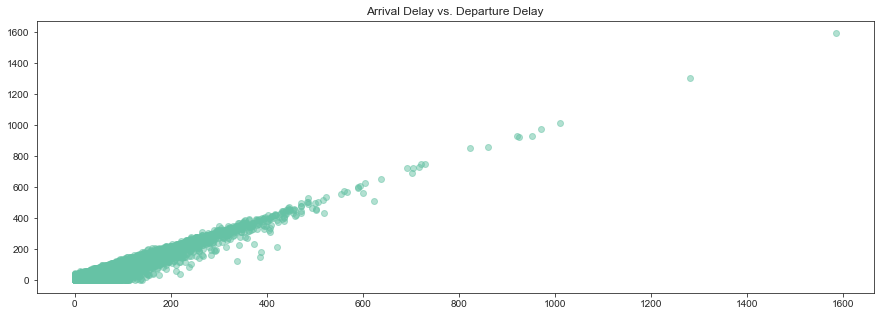

In [8]:
plt.figure(figsize = (15,5))
plt.title("Arrival Delay vs. Departure Delay")
plt.scatter(df_train['Arrival Delay in Minutes'], df_train['Departure Delay in Minutes'], alpha = 0.5, c = sns.color_palette("Set2")[0])

In [9]:
null_rows_idx = df_train.isnull().any(axis=1)
df_train.loc[null_rows_idx].head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
213,213,49608,Female,Loyal Customer,38,Business travel,Eco,109,5,3,3,3,5,5,5,5,5,2,4,1,1,5,31,NaN,satisfied
1124,1124,73442,Male,Loyal Customer,53,Personal Travel,Eco,1012,3,2,3,4,4,3,4,4,4,4,4,3,3,4,38,NaN,neutral or dissatisfied
1529,1529,71178,Male,Loyal Customer,39,Business travel,Business,733,2,5,5,5,2,4,3,2,2,2,2,2,2,3,11,NaN,neutral or dissatisfied
2004,2004,72940,Female,disloyal Customer,26,Business travel,Business,1035,3,3,3,1,2,3,2,2,3,3,4,5,5,2,41,NaN,neutral or dissatisfied
2108,2108,116374,Female,Loyal Customer,24,Personal Travel,Eco,417,2,1,2,2,5,2,5,5,1,4,2,1,2,5,1,NaN,neutral or dissatisfied


In [10]:
df_train_null = df_train[['Departure Delay in Minutes', 'Arrival Delay in Minutes']]
imputer = IterativeImputer()
imputed = imputer.fit_transform(df_train_null)

In [11]:
df_train_cleaned = df_train.copy()
df_train_cleaned.loc[:, ['Departure Delay in Minutes', 'Arrival Delay in Minutes']] = imputed
df_train_cleaned.loc[null_rows_idx].head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
213,213,49608,Female,Loyal Customer,38,Business travel,Eco,109,5,3,3,3,5,5,5,5,5,2,4,1,1,5,31.0,31.109284,satisfied
1124,1124,73442,Male,Loyal Customer,53,Personal Travel,Eco,1012,3,2,3,4,4,3,4,4,4,4,4,3,3,4,38.0,37.970828,neutral or dissatisfied
1529,1529,71178,Male,Loyal Customer,39,Business travel,Business,733,2,5,5,5,2,4,3,2,2,2,2,2,2,3,11.0,11.504871,neutral or dissatisfied
2004,2004,72940,Female,disloyal Customer,26,Business travel,Business,1035,3,3,3,1,2,3,2,2,3,3,4,5,5,2,41.0,40.911490,neutral or dissatisfied
2108,2108,116374,Female,Loyal Customer,24,Personal Travel,Eco,417,2,1,2,2,5,2,5,5,1,4,2,1,2,5,1.0,1.702665,neutral or dissatisfied


### 2.2. Handling Outliers
In this section, we will first detect outliers in the training set using Isolation Forest. Contamination = 0.01 is chosen since this filters out proper number of outliers. </br>
Secondly, columns with *Flight Distance*>4500 will be brutally removed. </br>
No outliers in the testing set should be removed.

In [12]:
X = df_train_cleaned[outlier_cols]

isolation_forest = IsolationForest(random_state=42, contamination = 0.01)
outlier_pred = isolation_forest.fit_predict(X)

df_train_no_outlier = df_train_cleaned.iloc[outlier_pred == 1]

df_train_outlier = df_train_cleaned.iloc[outlier_pred == -1]
print('dropped rows:', df_train_outlier.shape[0])

dropped rows: 1040


In [13]:
df_train_outlier[outlier_cols].describe()

,Age,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes
count,1040.000000,1040.000000,1040.000000,1040.000000
mean,39.602885,1523.594231,261.789423,265.106537
std,16.235662,1179.397409,118.309202,117.906445
min,7.000000,67.000000,69.000000,81.000000
25%,26.000000,486.750000,196.000000,195.000000
50%,40.000000,1076.000000,233.000000,239.000000
75%,52.000000,2455.000000,296.000000,299.000000
max,80.000000,4963.000000,1592.000000,1584.000000


In [14]:
df_train_no_outlier = df_train_no_outlier[df_train_no_outlier['Flight Distance']<4500]

In [ ]:
profile2 = df_train_no_outlier.profile_report(
    title="Report without correlations",
    correlations=None,
)
profile2.to_file("../data/airline_train_profile_no_outlier.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

### 2.3. Normalization and Imputation Pipelines
1. *normalize_preprocessing*: Normalization pipeline to facilitate certain distance-based models
    *imputing_preprocessing*: Imputatin pipeline to generate dataset for tree-based models
2. Prepare both training and testing set for modelling part

In [ ]:
def log_transform(x):
    return np.log(x + 1)
def non_transform(x):
    return x

log_pipeline = make_pipeline(
#    SimpleImputer(strategy="median"),
    IterativeImputer(),
    FunctionTransformer(log_transform, feature_names_out="one-to-one"))

iterative_impute_pipeline = make_pipeline(
    IterativeImputer(),
    FunctionTransformer(non_transform, feature_names_out="one-to-one"))

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

knn_impute_pipeline = make_pipeline(
    KNNImputer(missing_values = 0, n_neighbors=5, weights='uniform', metric='nan_euclidean'))

default_num_pipeline = make_pipeline(StandardScaler())

normalize_preprocessing = ColumnTransformer([
    ("log", log_pipeline, ['Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']),
    ("cat", cat_pipeline, categorical_cols),
    ("std", default_num_pipeline, ['Age']),
    ("score", knn_impute_pipeline, satisfaction_cols)
    ],
    remainder='passthrough',
    verbose_feature_names_out = False
    )

imputing_preprocessing = ColumnTransformer([
    ("iter", iterative_impute_pipeline, ['Departure Delay in Minutes', 'Arrival Delay in Minutes']),
    ("cat", cat_pipeline, categorical_cols),
    ("score", knn_impute_pipeline, satisfaction_cols)
    ],
    remainder='passthrough',
    verbose_feature_names_out = False
    )

Training Datasets

In [ ]:
airplane_train = df_train_no_outlier.copy()
airplane_train = imputing_preprocessing.fit_transform(airplane_train)
airplane_train = pd.DataFrame(airplane_train,
    columns=imputing_preprocessing.get_feature_names_out(),
    index=df_train_no_outlier.index)
airplane_train.drop(columns = ['Unnamed: 0', 'id'], inplace = True)
airplane_train.head(5)

In [ ]:
airplane_train_normalized = normalize_preprocessing.fit_transform(df_train_no_outlier)
airplane_train_normalized = pd.DataFrame(airplane_train_normalized,
    columns=normalize_preprocessing.get_feature_names_out(),
    index=df_train_no_outlier.index)
airplane_train_normalized.drop(columns = ['Unnamed: 0', 'id'], inplace = True)
airplane_train_normalized.head(5)

In [ ]:
profile3 = airplane_train_normalized.profile_report(
    title="Report without correlations",
    correlations=None,
)
profile3.to_file("../data/airline_train_profile_normalized.html")

Testing Datasets

In [ ]:
airplane_test = df_test.copy()
airplane_test = imputing_preprocessing.fit_transform(airplane_test)
airplane_test = pd.DataFrame(airplane_test,
    columns=imputing_preprocessing.get_feature_names_out(),
    index=df_test.index)
airplane_test.drop(columns = ['Unnamed: 0', 'id'], inplace = True)
airplane_test.head(5)

In [ ]:
airplane_test_normalized = normalize_preprocessing.fit_transform(df_test)
airplane_test_normalized = pd.DataFrame(airplane_test_normalized,
    columns=normalize_preprocessing.get_feature_names_out(),
    index=df_test.index)
airplane_test_normalized.drop(columns = ['Unnamed: 0', 'id'], inplace = True)
airplane_test_normalized.head(5)

### 2.4. Save processed file to local

In [ ]:
airplane_train.to_csv('../data/airplane_train_processed.csv', index=False)
airplane_train_normalized.to_csv('../data/airplane_train_processed_normalized.csv', index=False)

airplane_test.to_csv('../data/airplane_test_processed.csv', index=False)
airplane_test_normalized.to_csv('../data/airplane_test_processed_normalized.csv', index=False)

In [ ]:
airplane_train.shape

In [ ]:
df_train_no_outlier.shape